<h1 align="center"><font size="5">Finding the Best Classifier with Python</font></h1>

In this notebook I run 4 classification algorithms. These algorithms are KNN, Support Vector Machines, Decision Tree, and Logistic Regression.

I find the best algorithm by performing accuracy evaluation methods like jaccard index and f1 score.

In [1]:
# import essential libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Dataset Information

This dataset is about past loans. The data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
# number of rows and columns
df.shape

(346, 10)

In [5]:
# data types
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

### Convert to date time object 

In [6]:
# convert due_date and effective_date column types to date time
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
# uniaue counts of each category within target variable
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

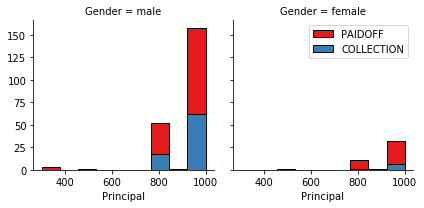

In [9]:
# import seaborn library for visualization
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

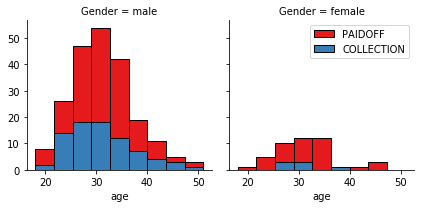

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

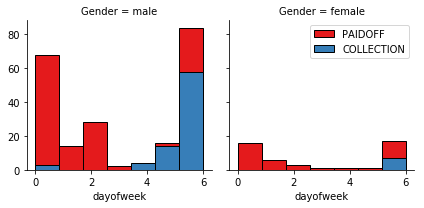

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


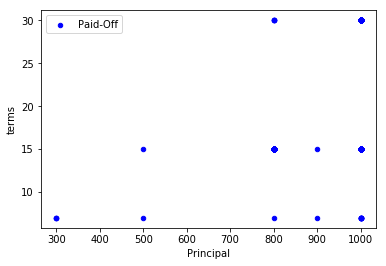

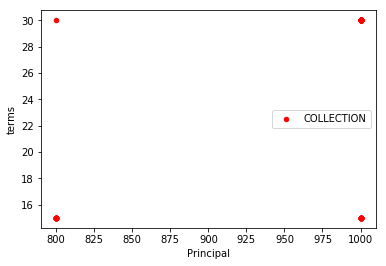

In [16]:
# visualize distribution of the loan_status based on the principal and terms
ax = df[df['loan_status'] == 'PAIDOFF'].plot(kind='scatter', x = 'Principal', y = 'terms', color = 'blue', label = 'Paid-Off');
df[df['loan_status'] == 'COLLECTION'].plot(kind='scatter', x = 'Principal', y = 'terms', color = 'red', label = 'COLLECTION');
plt.show()

## One Hot Encoding  
#### How about education?

In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [18]:
df.education.value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

#### Feature befor One Hot Encoding

In [19]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [20]:
# add loan_status_binary column with binary values for loan_status
df['loan_status_binary'] = df['loan_status'].apply(lambda x: 1 if (x=='PAIDOFF')  else 0)
df

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,loan_status_binary
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,1
5,7,7,PAIDOFF,1000,30,2016-09-09,2016-10-08,36,college,0,4,1,1
6,8,8,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,0,4,1,1
7,9,9,PAIDOFF,800,15,2016-09-10,2016-09-24,26,college,0,5,1,1
8,10,10,PAIDOFF,300,7,2016-09-10,2016-09-16,29,college,0,5,1,1
9,11,11,PAIDOFF,1000,15,2016-09-10,2016-10-09,39,High School or Below,0,5,1,1


In [21]:
# extract feature set
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1
5,1000,30,36,0,1,0,0,1
6,1000,30,28,0,1,0,0,1
7,800,15,26,0,1,0,0,1
8,300,7,29,0,1,0,0,1
9,1000,15,39,0,1,0,1,0


### Feature selection

Lets define feature sets, X:

In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [23]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [24]:
# need target feature to be binary for KNN and logistic regression
y_binary = df['loan_status_binary'].values
y_binary[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [25]:
X_norm= preprocessing.StandardScaler().fit(X).transform(X)
X_norm[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

I use the training set to build an accurate model. Then I use the test set to report the accuracy of the model
I use the following algorithms:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# K Nearest Neighbor (KNN)
I need find the best k to build the model with the best accuracy.  

In [26]:
# train test split with sklearn
from sklearn.model_selection import train_test_split
Xknn_train, Xknn_test, yknn_train, yknn_test = train_test_split(X_norm, y, test_size=.2, random_state=20)
print('Train Set:', Xknn_train.shape, yknn_train.shape)
print('Test Set:', Xknn_test.shape, yknn_test.shape)

Train Set: (276, 8) (276,)
Test Set: (70, 8) (70,)


In [27]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfusionMx = [];
for n in range(1,Ks):
    surround = KNeighborsClassifier(n_neighbors = n).fit(Xknn_train, yknn_train)
    yknn_pred = surround.predict(Xknn_test)
    mean_acc[n-1] = metrics.accuracy_score(yknn_test, yknn_pred)
    
    std_acc[n-1] = np.std(yknn_pred==yknn_test)/np.sqrt(yknn_pred.shape[0])
    
mean_acc

array([0.6       , 0.57142857, 0.6       , 0.68571429, 0.67142857,
       0.67142857, 0.65714286, 0.71428571, 0.64285714, 0.62857143,
       0.65714286, 0.68571429, 0.62857143, 0.64285714])

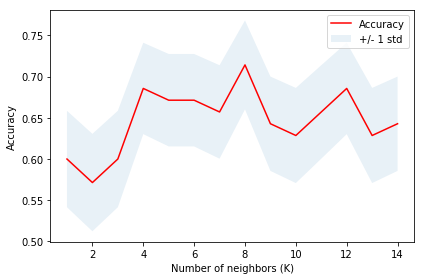

In [28]:
plt.plot(range(1,Ks), mean_acc, 'r')
plt.fill_between(range(1,Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha = .1)
plt.legend(('Accuracy', '+/- 1 std'))
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors (K)')
plt.tight_layout()
plt.show()

In [29]:
print('The highest accuracy is achieved with', '{0:.2f}'.format(mean_acc.max()), 'with k=', mean_acc.argmax()+1)

The highest accuracy is achieved with 0.71 with k= 8


In [30]:
# we train the model with k=8 neighbors which gives the most accurate prediction
neighbor = KNeighborsClassifier(n_neighbors = 8).fit(Xknn_train, yknn_train)
neighbor

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform')

In [31]:
# show model prediction with best k (8)
yknn_pred = neighbor.predict(Xknn_test)
yknn_pred

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [32]:
# a comparison between train and test set accuracy for best k
print('Train Set Accuracy:', metrics.accuracy_score(yknn_train, neighbor.predict(Xknn_train)))
print('Test Set Accuracy:', metrics.accuracy_score(yknn_test, yknn_pred))

Train Set Accuracy: 0.822463768115942
Test Set Accuracy: 0.7142857142857143


# Decision Tree

In [33]:
# train_test split for decision tree moodel
Xtree_train, Xtree_test, ytree_train, ytree_test = train_test_split(X, y, test_size = .2, random_state= 20)

In [34]:
# import library and instantiate decision tree classifier
from sklearn.tree import DecisionTreeClassifier
decisionloan = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
decisionloan

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
# fit the data
decisionloan.fit(Xtree_train, ytree_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [36]:
# prediction
ytree_pred = decisionloan.predict(Xtree_test)
print(ytree_pred [0:10])
print(ytree_test [0:10])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [37]:
# accuracy of the model
accuracy = metrics.accuracy_score(ytree_test, ytree_pred)
print('Decision Tree Model Accuracy:', '{0:.2f}'.format(accuracy))

Decision Tree Model Accuracy: 0.63


In [38]:
# install packages needed for decision tree visualization
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

In [39]:
# import libraries
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as decisionimg
from sklearn import tree
%matplotlib inline

In [40]:
df1 = df[['Principal','terms','age','Gender','weekend','loan_status']]
df1 = pd.concat([df1,pd.get_dummies(df['education'])], axis=1)
df1.drop(['Master or Above'], axis = 1,inplace=True)
df1 = df1[['Principal','terms','age','Gender','weekend','Bechalor','High School or Below','college','loan_status']]
df1

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college,loan_status
0,1000,30,45,0,0,0,1,0,PAIDOFF
1,1000,30,33,1,0,1,0,0,PAIDOFF
2,1000,15,27,0,0,0,0,1,PAIDOFF
3,1000,30,28,1,1,0,0,1,PAIDOFF
4,1000,30,29,0,1,0,0,1,PAIDOFF
5,1000,30,36,0,1,0,0,1,PAIDOFF
6,1000,30,28,0,1,0,0,1,PAIDOFF
7,800,15,26,0,1,0,0,1,PAIDOFF
8,300,7,29,0,1,0,0,1,PAIDOFF
9,1000,15,39,0,1,0,1,0,PAIDOFF


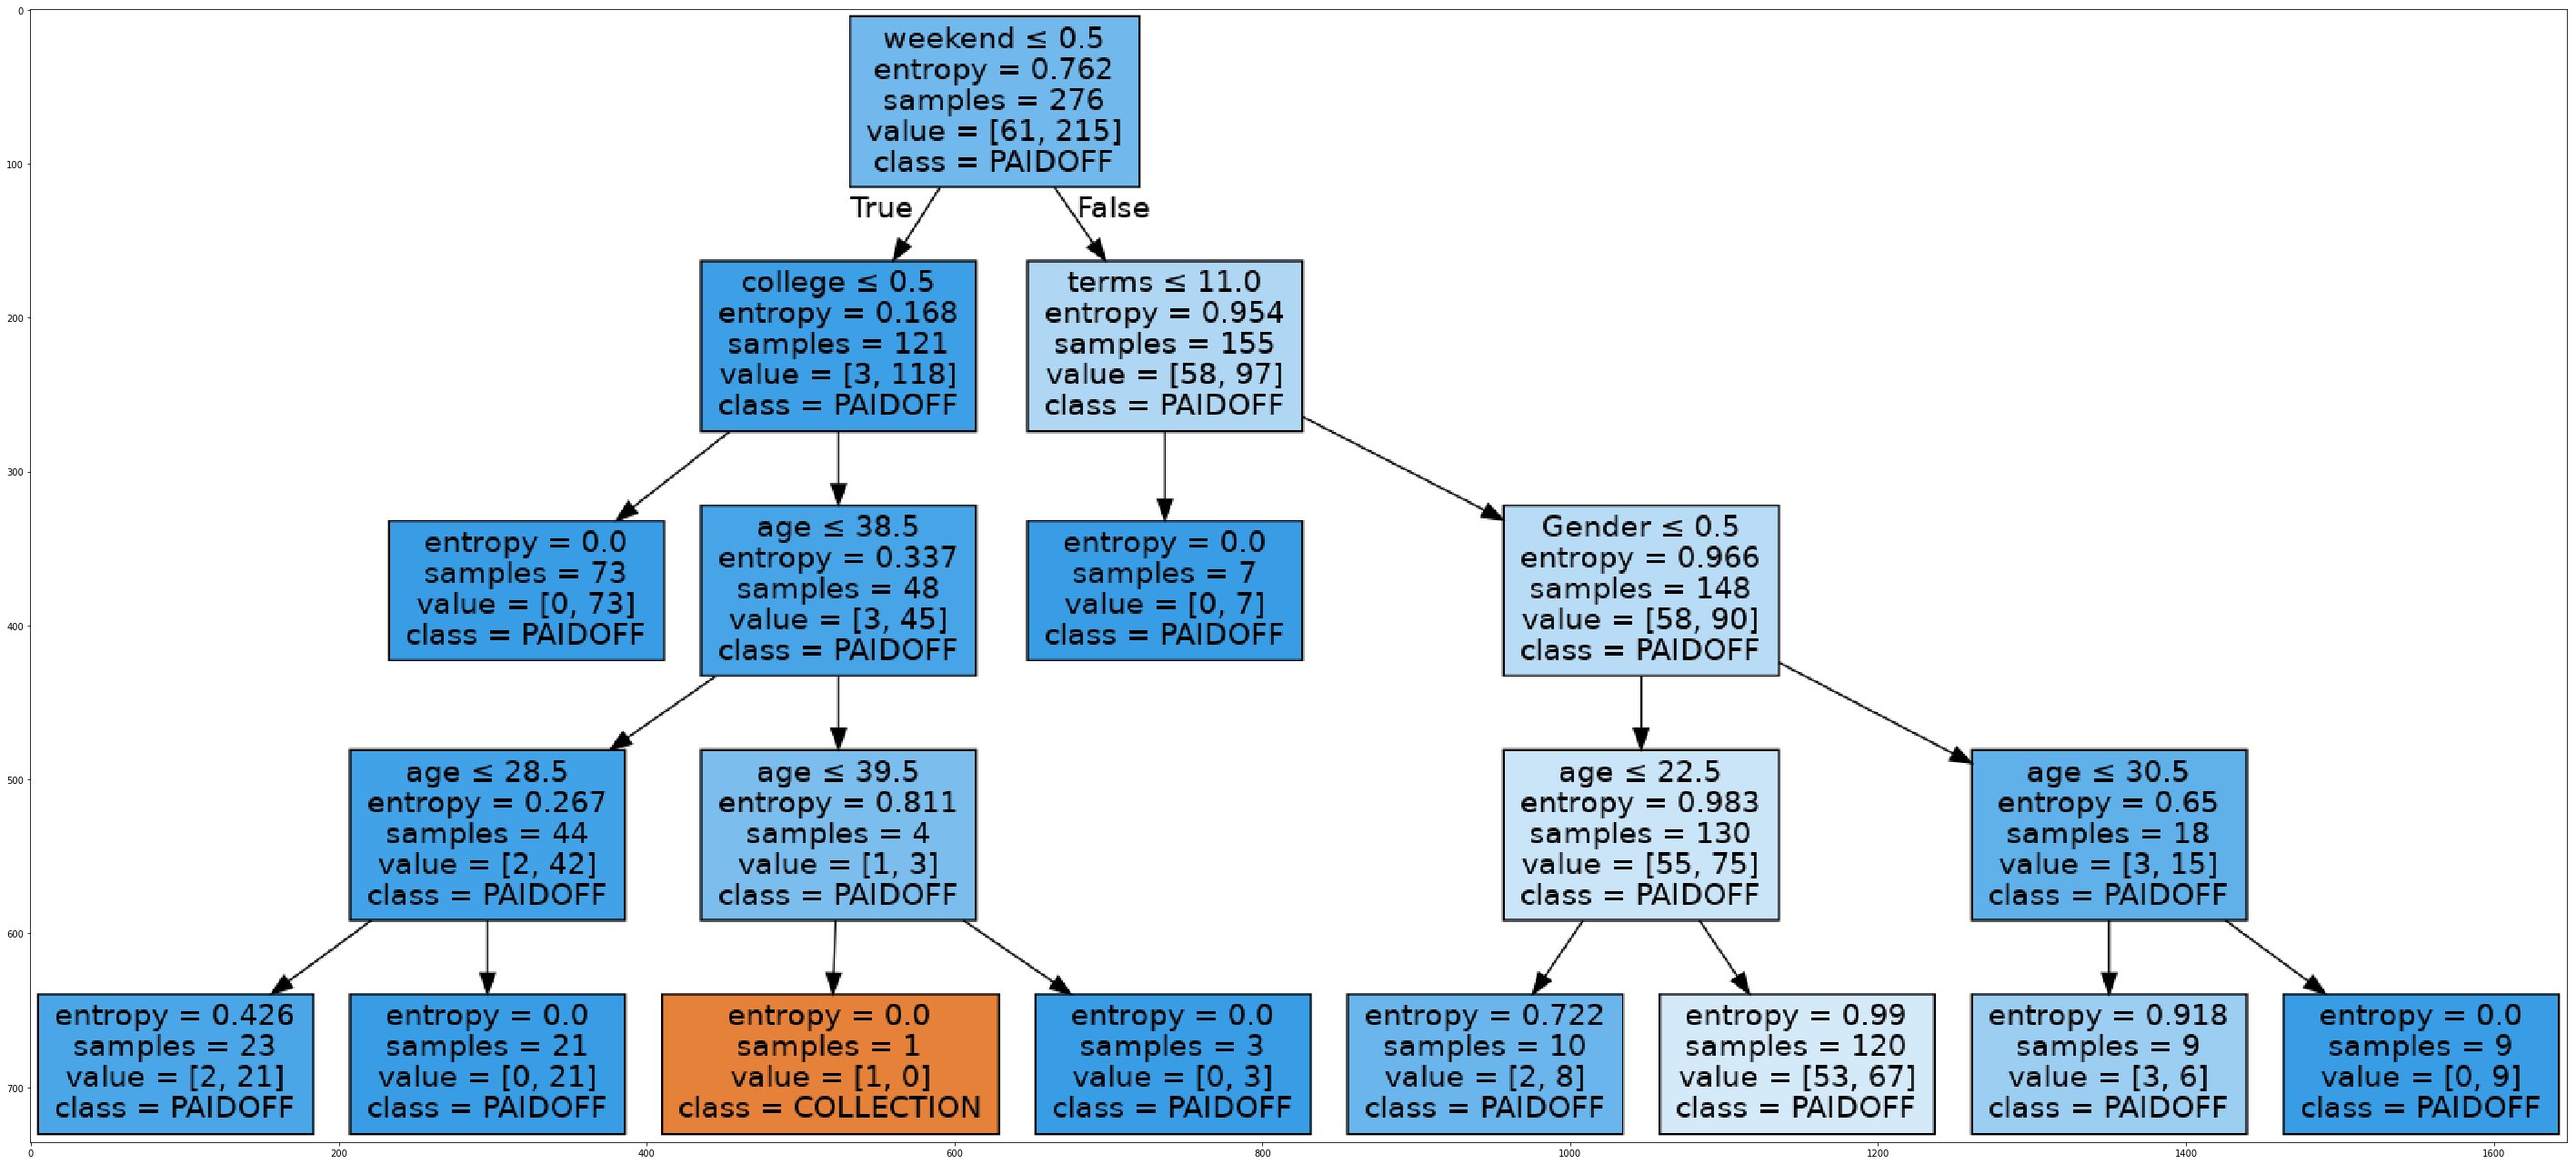

In [41]:
# decision tree visualization
dot_data = StringIO()
imagename = "loantree.png"
featurenames = df1.columns[0:8]
targetnames = df1['loan_status'].unique().tolist()
output = tree.export_graphviz(decisionloan, feature_names = featurenames, out_file = dot_data, class_names=np.unique(ytree_train), filled = True, special_characters = True, rotate = False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(imagename)
img = decisionimg.imread(imagename)
plt.figure(figsize=(50, 100))
plt.imshow(img, interpolation = 'nearest')

# Support Vector Machine

In [42]:
# import nedded libraries
import pylab as py
import scipy.optimize as optimum
from sklearn import svm

In [43]:
df.loan_status.value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [44]:
# train_test split for svm model
Xsvm_train, Xsvm_test, ysvm_train, ysvm_test = train_test_split(X, y_binary, test_size = .2, random_state= 20)

In [45]:
# build svm classifier with polynomial kernel type
svm_clf = svm.SVC(kernel = 'rbf')
svm_clf.fit(Xsvm_train, ysvm_train)

ysvm_pred = svm_clf.predict(Xsvm_test)
ysvm_pred[0:5]

array([1, 1, 1, 1, 1])

In [46]:
# start evaluation by importing the essential libraries
from sklearn.metrics import classification_report, confusion_matrix
import itertools

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.64      1.00      0.78        45

   micro avg       0.64      0.64      0.64        70
   macro avg       0.32      0.50      0.39        70
weighted avg       0.41      0.64      0.50        70



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(30.525000000000063, 0.5, 'True')

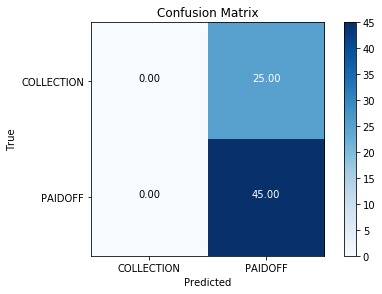

In [47]:
# visualization of the confusion matrix
classes = ['COLLECTION','PAIDOFF']
matrix = confusion_matrix(ysvm_test, ysvm_pred, labels=[0,1])
np.set_printoptions(precision=2)
print(classification_report(ysvm_test, ysvm_pred))
plt.figure()
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    plt.text(j, i, format(matrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')

# Logistic Regression

In [48]:
# import libraries
import pylab as pl
from sklearn.linear_model import LogisticRegression

In [49]:
from sklearn.model_selection import train_test_split
Xlog_train, Xlog_test, ylog_train, ylog_test = train_test_split(X_norm, y_binary, test_size=0.2, random_state=20)
print ('Train set:', Xlog_train.shape,  ylog_train.shape)
print ('Test set:', Xlog_test.shape,  ylog_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [50]:
Logistic = LogisticRegression(C=0.01, solver='liblinear').fit(Xlog_train,ylog_train)
Logistic

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
ylog_pred = Logistic.predict(Xlog_test)
ylog_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [52]:
ylog_pred_prob = Logistic.predict_proba(Xlog_test)
ylog_pred_prob

array([[0.47, 0.53],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.47, 0.53],
       [0.25, 0.75],
       [0.47, 0.53],
       [0.33, 0.67],
       [0.25, 0.75],
       [0.44, 0.56],
       [0.46, 0.54],
       [0.46, 0.54],
       [0.4 , 0.6 ],
       [0.3 , 0.7 ],
       [0.46, 0.54],
       [0.31, 0.69],
       [0.47, 0.53],
       [0.45, 0.55],
       [0.33, 0.67],
       [0.32, 0.68],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.33, 0.67],
       [0.41, 0.59],
       [0.3 , 0.7 ],
       [0.3 , 0.7 ],
       [0.44, 0.56],
       [0.46, 0.54],
       [0.48, 0.52],
       [0.46, 0.54],
       [0.33, 0.67],
       [0.44, 0.56],
       [0.46, 0.54],
       [0.4 , 0.6 ],
       [0.48, 0.52],
       [0.46, 0.54],
       [0.47, 0.53],
       [0.48, 0.52],
       [0.46, 0.54],
       [0.46, 0.54],
       [0.47, 0.53],
       [0.45, 0.55],
       [0.33, 0.67],
       [0.47, 0.53],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.38, 0.62],
       [0.47,

# Model Evaluation using Test set

In [53]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation 

In [55]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# Preprocessing for test set

In [56]:
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,male,3
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,female,3
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,male,4
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,male,4


In [57]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# add loan_status_binary column with binary values for loan_status
test_df['loan_status_binary'] = test_df['loan_status'].apply(lambda x: 1 if (x=='PAIDOFF')  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,loan_status_binary
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0,1
1,5,5,PAIDOFF,300,7,2016-09-08,2016-10-07,35,Master or Above,0,3,0,1
2,21,21,PAIDOFF,1000,30,2016-09-08,2016-09-22,43,High School or Below,1,3,0,1
3,24,24,PAIDOFF,1000,30,2016-09-09,2016-10-08,26,college,0,4,1,1
4,35,35,PAIDOFF,800,15,2016-09-09,2016-10-08,29,Bechalor,0,4,1,1


In [58]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0
5,700,15,33,0,1,0,1,0
6,1000,15,24,0,1,0,0,1
7,1000,30,32,0,1,1,0,0
8,800,15,27,1,1,0,0,1
9,1000,15,37,0,1,0,0,1


In [59]:
X_test = Feature_test
X_test[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [60]:
y_test = test_df['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [61]:
y_test_binary = test_df['loan_status_binary'].values
y_test_binary[0:5]

array([1, 1, 1, 1, 1])

In [62]:
X_test_norm = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test_norm[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.49,  0.93,  3.06,  1.98, -4.12,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51, -4.12, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98, -4.12, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.24, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.24,  2.4 , -0.8 , -0.86]])

# KNN

In [63]:
# model prediction with best k (8)
ytestknn_pred = neighbor.predict(X_test_norm)
ytestknn_pred

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

In [64]:
print('knn_jaccard score is:', '{0:.2f}'.format(jaccard_similarity_score(y_test, ytestknn_pred)))
print('knn_F1 score is:', '{0:.2f}'.format(f1_score(y_test, ytestknn_pred, average='weighted')))

knn_jaccard score is: 0.67
knn_F1 score is: 0.63


# Decision Tree

In [65]:
ytesttree_pred = decisionloan.predict(X_test)

In [66]:
print('decision_jaccard score is:', '{0:.2f}'.format(jaccard_similarity_score(y_test, ytesttree_pred)))
print('decision_F1 score is:', '{0:.2f}'.format(f1_score(y_test, ytesttree_pred, average='weighted')))

decision_jaccard score is: 0.74
decision_F1 score is: 0.63


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Support Vector Machine

In [67]:
ytestsvm_pred = svm_clf.predict(X_test)

In [68]:
print('SVM_jaccard score is:', '{0:.2f}'.format(jaccard_similarity_score(y_test_binary, ytestsvm_pred)))
print('SVM_F1 score is:', '{0:.2f}'.format(f1_score(y_test_binary, ytestsvm_pred, average='weighted')))

SVM_jaccard score is: 0.74
SVM_F1 score is: 0.63


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Logistic Regression

In [69]:
ytestlog_pred = Logistic.predict(X_test_norm)

In [70]:
print('log_jaccard score is:', '{0:.2f}'.format(jaccard_similarity_score(y_test_binary, ytestlog_pred)))
print('log_F1 score is:', '{0:.2f}'.format(f1_score(y_test_binary, ytestlog_pred, average='weighted')))

log_jaccard score is: 0.74
log_F1 score is: 0.63


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [71]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(Xlog_train,ylog_train)
ylogpred_prob = LR2.predict_proba(X_test_norm)
from sklearn.metrics import log_loss
log_loss(y_test_binary, ylogpred_prob)

0.5676949399859658

# Report
Accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67    | 0.63     | NA      |
| Decision Tree      | 0.74    | 0.63     | NA      |
| SVM                | 0.74    | 0.63     | NA      |
| LogisticRegression | 0.74    | 0.63     | 0.56    |

# Conclusion
According to the evaluation matrices, all three algorithms of Decision Tree, Support Vector Machine, and Logistic Regression have the same accuracy. KNN with k=8 has the lowest accuracy compared to other machine learning algorithms.